In [169]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.int8)
number_of_instance = 60000
X = X[:number_of_instance]
y = y[:number_of_instance]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [170]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# PCA

In [171]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=200)
# X_train = pca.fit_transform(X_train)

In [172]:
# sum(pca.explained_variance_ratio_)

In [173]:
# X_test = pca.transform(X_test)

# Neural Networks

In [174]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [175]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [192]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(self.input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.view(-1, self.input_size ) 
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.log_softmax(self.fc3(x))
        return x

model = Net(X_train.shape[1])


In [193]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [194]:
from sklearn.metrics import precision_score, recall_score

In [195]:
num_epochs = 5

train_losses = []
train_precisions = []
train_recalls = []

test_losses = []
test_precisions = []
test_recalls = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for images, labels in train_loader:
        images, labels = images, labels
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    
    train_losses.append(running_loss/len(train_loader))
    train_precisions.append(precision)
    train_recalls.append(recall)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss/len(train_loader):.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
    
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images, labels
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    
    test_losses.append(running_loss/len(test_loader))
    test_precisions.append(precision)
    test_recalls.append(recall)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Testing Loss: {running_loss/len(test_loader):.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

Epoch [1/5], Training Loss: 0.2435, Precision: 0.9269, Recall: 0.9267
Epoch [1/5], Testing Loss: 0.1386, Precision: 0.9593, Recall: 0.9594
Epoch [2/5], Training Loss: 0.1087, Precision: 0.9676, Recall: 0.9676
Epoch [2/5], Testing Loss: 0.1292, Precision: 0.9642, Recall: 0.9641
Epoch [3/5], Training Loss: 0.0721, Precision: 0.9781, Recall: 0.9781
Epoch [3/5], Testing Loss: 0.1278, Precision: 0.9664, Recall: 0.9663
Epoch [4/5], Training Loss: 0.0525, Precision: 0.9837, Recall: 0.9837
Epoch [4/5], Testing Loss: 0.1437, Precision: 0.9674, Recall: 0.9670
Epoch [5/5], Training Loss: 0.0480, Precision: 0.9849, Recall: 0.9848
Epoch [5/5], Testing Loss: 0.1527, Precision: 0.9688, Recall: 0.9687


In [180]:
import matplotlib.pyplot as plt

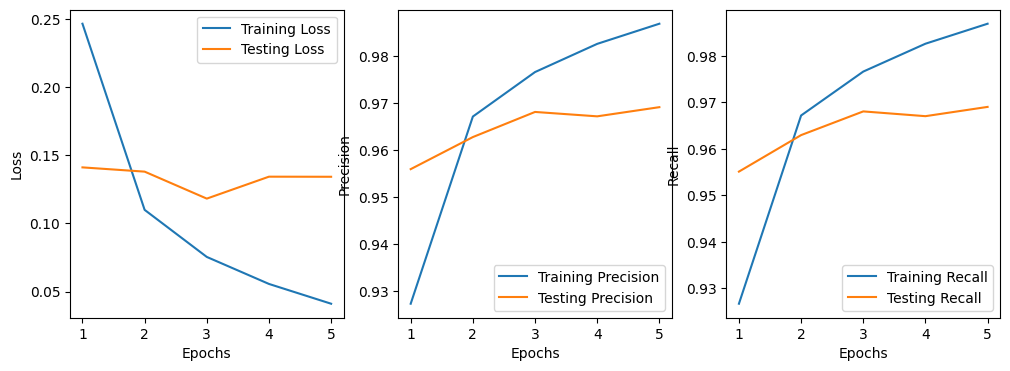

In [181]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, train_precisions, label='Training Precision')
plt.plot(epochs, test_precisions, label='Testing Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, train_recalls, label='Training Recall')
plt.plot(epochs, test_recalls, label='Testing Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

# SVM

In [182]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear', gamma='scale', random_state=42)

svm_model.fit(X_train, y_train)


SVC(random_state=42)

In [183]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = svm_model.predict(X_train)

accuracy = accuracy_score(y_train, y_pred)
print(f'Train Accuracy: {accuracy:.4f}')
y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Train Accuracy: {accuracy:.4f}')

Train Accuracy: 0.9856
Train Accuracy: 0.9637


In [184]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1175
           1       0.98      0.98      0.98      1322
           2       0.94      0.96      0.95      1174
           3       0.96      0.95      0.95      1219
           4       0.96      0.97      0.97      1176
           5       0.97      0.95      0.96      1104
           6       0.97      0.97      0.97      1177
           7       0.93      0.97      0.95      1299
           8       0.97      0.95      0.96      1160
           9       0.97      0.95      0.96      1194

    accuracy                           0.96     12000
   macro avg       0.96      0.96      0.96     12000
weighted avg       0.96      0.96      0.96     12000



# KNN

In [185]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)

knn_model.fit(X_train, y_train)


KNeighborsClassifier()

In [186]:
y_pred = knn_model.predict(X_train)

accuracy = accuracy_score(y_train, y_pred)
print(f'Train Accuracy: {accuracy:.4f}')
y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Train Accuracy: {accuracy:.4f}')

Train Accuracy: 0.9620
Train Accuracy: 0.9637


In [187]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1175
           1       0.98      0.98      0.98      1322
           2       0.94      0.96      0.95      1174
           3       0.96      0.95      0.95      1219
           4       0.96      0.97      0.97      1176
           5       0.97      0.95      0.96      1104
           6       0.97      0.97      0.97      1177
           7       0.93      0.97      0.95      1299
           8       0.97      0.95      0.96      1160
           9       0.97      0.95      0.96      1194

    accuracy                           0.96     12000
   macro avg       0.96      0.96      0.96     12000
weighted avg       0.96      0.96      0.96     12000

